# PySQkit introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysqkit as sq
from pysqkit.util.linalg import tensor_prod

# Example single-qubit usage

In [2]:
fluxonium = sq.qubits.Fluxonium(
    label= 'Q1', 
    joseph_energy=3.395, 
    charge_energy=0.479, 
    induct_energy=0.132, 
    dim_hilbert = 150, 
    flux = 0.5
)

wf_dataset = fluxonium.wave_function(
    phase=np.linspace(-4*np.pi, 4*np.pi, 1000), 
    levels=range(3)
)

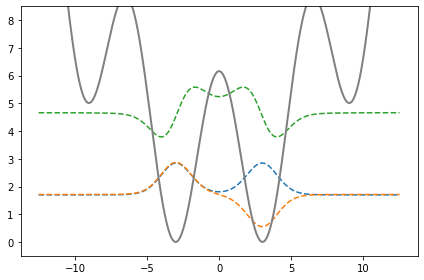

In [3]:
fig, ax = plt.subplots()

amp = 2*wf_dataset.joseph_energy/3
pot_offset = wf_dataset.potential.min()

shifted_wave_funcs = amp*wf_dataset.wave_func + wf_dataset.energy.data[:, np.newaxis] - pot_offset
for level in wf_dataset.level:
    ax.plot(wf_dataset.phase, shifted_wave_funcs.sel(level=level), '--')
    
ax.plot(wf_dataset.phase, (wf_dataset.potential - pot_offset), color='gray', lw=2)
ax.set_ylim(-0.5, 8.5)
plt.tight_layout()
plt.show()

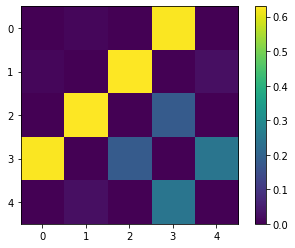

In [4]:
mat_elems = fluxonium.mat_elements(operator='charge_op', levels=5)
plt.imshow(np.abs(mat_elems))
plt.colorbar()
plt.show()

In [5]:
fluxonium.hamiltonian().shape

(150, 150)

In [6]:
eig_enegies, eig_states = fluxonium.eig_states(levels=5)
fluxonium.basis.transform(eig_states)

In [7]:
diag_hamil = fluxonium.hamiltonian()

In [8]:
assert np.allclose(eig_enegies, np.diag(diag_hamil))

In [9]:
assert np.allclose(diag_hamil, np.diag(np.diag(diag_hamil)))

In [10]:
fluxonium.hamiltonian(as_qobj=True)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[-1.06987386e+00 -1.47828547e-16  7.24457436e-16 -2.17156325e-16
   1.63087111e-16]
 [-1.47828547e-16 -1.05599230e+00  1.05339202e-15 -1.75915170e-16
  -1.75237350e-15]
 [ 8.73007203e-16  1.05339202e-15  1.89492215e+00  5.12379994e-16
  -6.63212287e-16]
 [-2.17156325e-16 -2.48555771e-16  5.12379994e-16  2.14840668e+00
  -2.52017457e-15]
 [ 4.57966998e-16 -1.75237350e-15  2.22044605e-16 -2.52017457e-15
   3.85387862e+00]]

In [11]:
fluxonium.charge_op(as_qobj=True)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0.-6.76249871e-33j 0.+1.07895259e-02j 0.+2.44987726e-15j
  0.+6.25803383e-01j 0.-4.75240184e-15j]
 [0.-1.07895259e-02j 0.+1.52572584e-32j 0.-6.29809277e-01j
  0.+2.89030589e-15j 0.-2.66318601e-02j]
 [0.-2.44987726e-15j 0.+6.29809277e-01j 0.-2.77133780e-32j
  0.-1.82041298e-01j 0.-2.81501662e-14j]
 [0.-6.25803383e-01j 0.-2.89030589e-15j 0.+1.82041298e-01j
  0.+2.05375602e-31j 0.-2.45345327e-01j]
 [0.+4.75240184e-15j 0.+2.66318601e-02j 0.+2.81501662e-14j
  0.+2.45345327e-01j 0.-1.61210932e-29j]]

In [12]:
np.allclose(np.abs(mat_elems.data), np.abs(fluxonium.charge_op()))

True

## Example two-qubit usage

In [13]:
fluxonium_A = sq.qubits.Fluxonium(
    label='A', 
    joseph_energy=5.5, 
    charge_energy=1.5, 
    induct_energy=1, 
    flux = 0.5, 
    dim_hilbert = 150
)

fluxonium_B = sq.qubits.Fluxonium(
    label='B', 
    joseph_energy=5.7, 
    charge_energy=1.2, 
    induct_energy=1, 
    flux = 0.5, 
    dim_hilbert = 150
)


coupled_sys = fluxonium_A.couple_to(fluxonium_B, coupling=sq.couplers.capacitive_coupling, strength=0.2)

In [14]:
sys_hamil = coupled_sys.hamiltonian()
bare_hamil = coupled_sys.bare_hamiltonian()
int_hamil = coupled_sys.int_hamiltonian()

In [15]:
bare_hamil.shape

(36, 36)

In [16]:
assert(np.allclose(sys_hamil, bare_hamil+int_hamil))

In [17]:
_, eig_states = fluxonium_A.eig_states(levels=6)
fluxonium_A.basis.transform(eig_states)

_, eig_states = fluxonium_B.eig_states(levels=6)
fluxonium_B.basis.transform(eig_states)

In [18]:
diag_hamil_A = fluxonium_A.hamiltonian()
diag_hamil_B = fluxonium_B.hamiltonian()

In [19]:
np.allclose(bare_hamil, tensor_prod([diag_hamil_A, np.eye(*diag_hamil_B.shape)]) + tensor_prod([np.eye(*diag_hamil_A.shape), diag_hamil_B]))

True

In [20]:
cap_coupling = sq.couplers.capacitive_coupling(
    qubits=[fluxonium_A, fluxonium_B],
    strength = 0.2,
)

In [21]:
cap_coupling.hamiltonian().shape

(36, 36)

In [22]:
np.allclose(int_hamil, cap_coupling.hamiltonian())

True

In [23]:
also_cap_coupling = sq.Coupling(
    prefactors=0.2,
    operators=dict(A=fluxonium_A.charge_op(), B=fluxonium_B.charge_op()),
    qubits=['A', 'B']
)

In [24]:
np.allclose(int_hamil, also_cap_coupling.hamiltonian())

True

In [25]:
double_cap_coupling = sq.Coupling(
    prefactors=[0.2, 0.2],
    operators=[dict(A=fluxonium_A.charge_op(), B=fluxonium_B.charge_op()), dict(A=fluxonium_A.charge_op(), B=fluxonium_B.charge_op())],
    qubits=['A', 'B']
)

In [26]:
np.allclose(2*int_hamil, double_cap_coupling.hamiltonian())

True